In [2]:
#importing libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt

#loading data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset["train"].to_pandas()

#data cleanup
df["job_posted_date"] = pd.to_datetime(df["job_posted_date"])
df["job_skills"] = df["job_skills"].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

#filter for data analyst data
df_DA = df[df["job_title_short"] == "Data Analyst"].copy()

In [4]:
#new column for month number
df_DA["job_posted_month_no"] = df_DA["job_posted_date"].dt.month

#explode job skills column and pivot
df_DA_explode = df_DA.explode("job_skills")
df_DA_pivot = df_DA_explode.pivot_table(index="job_posted_month_no", columns="job_skills", aggfunc="size", fill_value=0)

#sort skills by count
df_DA_pivot.loc["Total"] = df_DA_pivot.sum()
df_DA_pivot = df_DA_pivot[df_DA_pivot.loc["Total"].sort_values(ascending=False).index]
df_DA_pivot = df_DA_pivot.drop("Total")

#month names for plotting
df_DA_pivot = df_DA_pivot.reset_index()
df_DA_pivot["job_posted_month"] = df_DA_pivot["job_posted_month_no"].apply(lambda x: pd.to_datetime(x, format="%m").strftime("%b"))
df_DA_pivot = df_DA_pivot.drop(columns="job_posted_month_no")


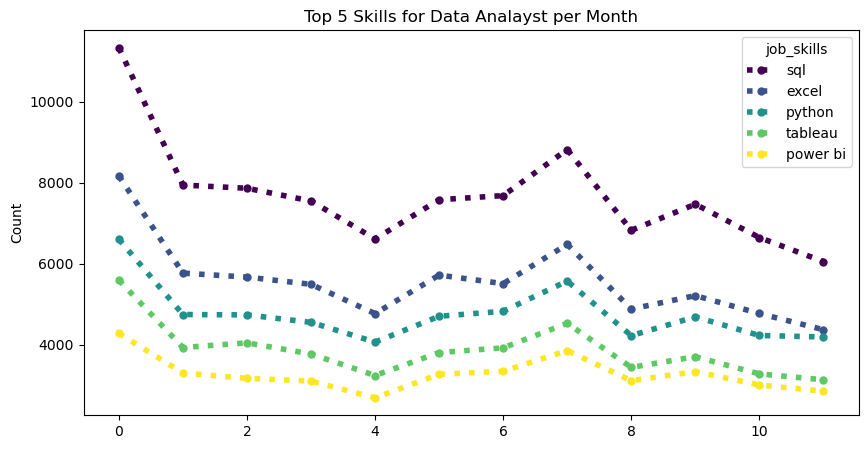

In [13]:
#get top 5 skills
df_DA_pivot.iloc[:, :5].plot(
    kind="line",
    linewidth="4",
    linestyle=":", #options: "-", "--", "-.", ":"
    colormap="viridis",
    marker="o",
    markersize=5,
    figsize=(10, 5)
)

plt.title("Top 5 Skills for Data Analayst per Month")
plt.ylabel("Count")
plt.xlabel("")
plt.show()

In [21]:
#explode the job skills into individual rows
df_exploded = df.explode("job_skills")

#calculate average salary and count of job postings per skill
skill_stats = df_exploded.groupby("job_skills").agg(
    skill_count = ("job_skills", "count"),
    median_salary = ("salary_year_avg", "median")
)

#get only the top 20 skills
skill_count = 20
skill_stats = skill_stats.sort_values(by="skill_count", ascending=False).head(skill_count)

skill_stats

,skill_count,median_salary
job_skills,,
sql,384849,120000.0
python,380909,125000.0
aws,145381,135000.0
azure,132527,125000.0
r,130892,119550.0
tableau,127213,111175.0
excel,127018,92500.0
spark,114609,140000.0
power bi,98147,102000.0


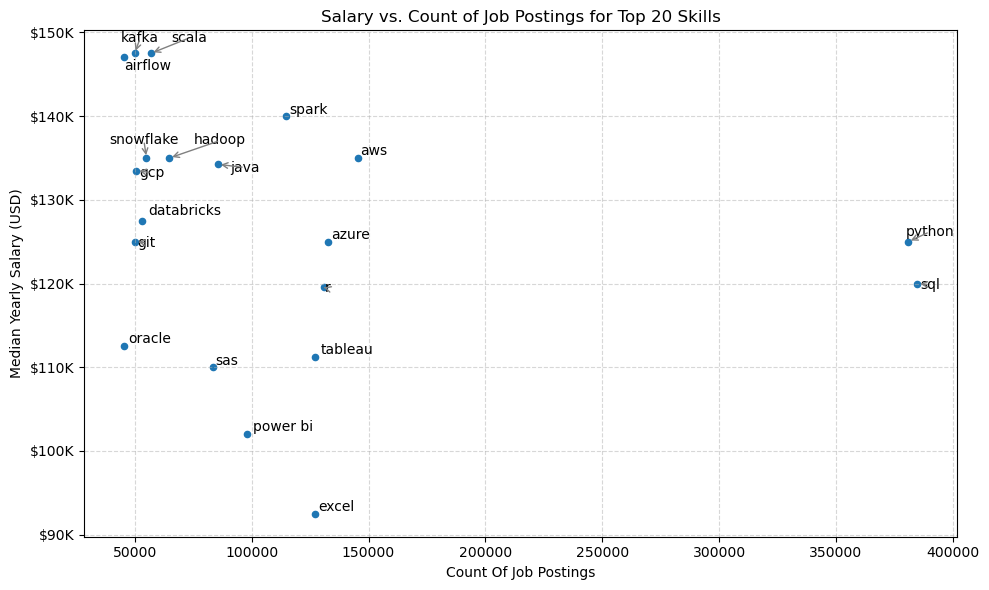

In [33]:
from adjustText import adjust_text


# Create scatter plot
ax = skill_stats.plot(kind="scatter", x="skill_count", y="median_salary", figsize=(10, 6))

# Add text labels
texts = []
for i, txt in enumerate(skill_stats.index):
    texts.append(
        plt.text(skill_stats["skill_count"].iloc[i], skill_stats["median_salary"].iloc[i], txt)
    )

# Adjust labels to avoid overlap
adjust_text(
    texts,
    arrowprops=dict(arrowstyle="->", color="gray", lw=1),
    expand_points=(1.2, 1.4),   # More spacing around points
    expand_text=(1.2, 1.4),     # More spacing around texts
    force_text=0.8,             # Increase repelling force between texts
    force_points=0.3            # Adjust force from points
)

# Format y-axis to show in $K
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f"${int(y/1000)}K"))

# Add labels and title
plt.xlabel("Count Of Job Postings")
plt.ylabel("Median Yearly Salary (USD)")
plt.title("Salary vs. Count of Job Postings for Top 20 Skills")

# Improve layout
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.show()